# (direct) analysis of events from $^{22}$Na decay
$^{22}$Na source activity is 10 uC

last edit Mar-11,2021

events collected using 
/Users/erezcohen/Desktop/PETsys/Software/PETsysAnalysis/CPP/BoxSi_proto2.1_event_collector

In [4]:
import sys; 
sys.path.insert(0, '/Users/erezcohen/Desktop/PETsys/Software/PETsysAnalysis/Python'); 
from PETsys_analysis_tools import *;
sys.path.insert(0, '/Users/erezcohen/Desktop/PETsys/Software/PETsysAnalysis/Python/BoxSi'); 
from proto21_tools import *;
%config InlineBackend.figure_format = 'retina'

In [8]:
# data_path = '/Users/erezcohen/Desktop/data/PETsys/BoxSi_proto2.1/GroupAnalyzer/'
data_path = '/Users/erezcohen/Desktop/data/PETsys/BoxSi_proto2.1/vth_2PE/'

In [2]:
dT = 10; # sec

In [23]:
events = pd.read_csv(data_path + 'vth12e_10_Na22_%dsec_events.csv'%dT)
KETEK_events = events[(events['detector']==3) | (events['detector']==12)]
SensL_events = events[(events['detector']==6) | (events['detector']==9)]
# statistics
print '%d events'%len(events),'(%.2f kHz)'%(float(len(events))/dT/1000)
for detector in [12,3,6,9,0]:
    print ('%.1f'%(float(100.*len(events[events.detector==detector]))/len(events))
           +'%'+' events of  of det. %d'%detector)

22982 events (2.30 kHz)
5.9% events of  of det. 12
6.1% events of  of det. 3
54.4% events of  of det. 6
33.5% events of  of det. 9
0.0% events of  of det. 0


# expectation for a 10uC $22$Na source:
activity: 0.37 MBq 
    
gamma efficiency: 9.1 %

In [10]:
activity_Bq = 0.37e6; # decays/sec
eff_gamma_511keV = 0.091;
exp_rate_Hz = activity_Bq * eff_gamma_511keV
print 'expected 511 keV gamma event rate: %.2f kHz'%(exp_rate_Hz/1000)

expected 511 keV gamma event rate: 33.67 kHz


## group cosmic event-groups into single "events" detected in each detector

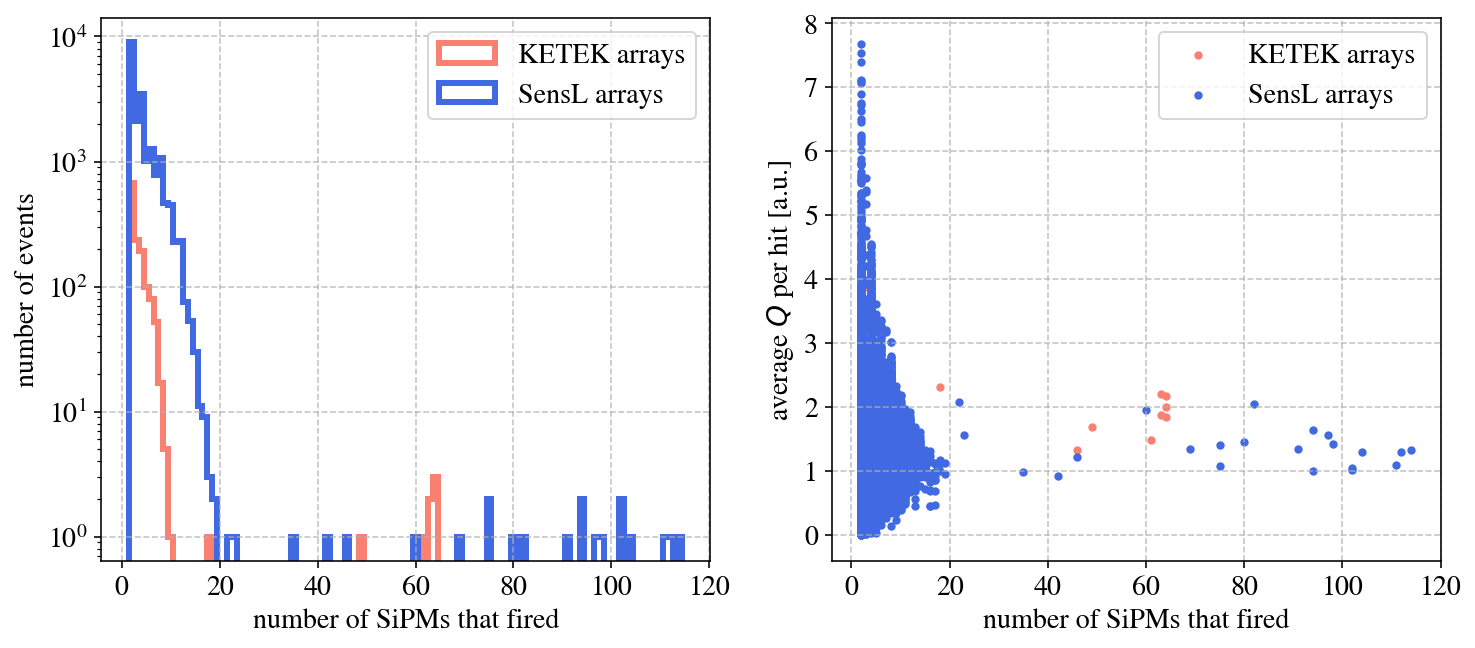

In [11]:
fig=plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
plot_discrete_histogram(KETEK_events['N(SiPMs)'],label='KETEK arrays',color='salmon')
plot_discrete_histogram(SensL_events['N(SiPMs)'],label='SensL arrays',color='royalblue')
set_axes(ax,x_label='number of SiPMs that fired',y_label='number of events',
         do_add_grid=True,do_add_legend=True,fontsize=14);
ax.set_yscale('log')

ax = fig.add_subplot(1,2,2)
plt.scatter(KETEK_events['N(SiPMs)'],KETEK_events['Qtot[a.u.]']/KETEK_events['N(SiPMs)'],s=10,label='KETEK arrays',color='salmon')
plt.scatter(SensL_events['N(SiPMs)'],SensL_events['Qtot[a.u.]']/SensL_events['N(SiPMs)'],s=10,label='SensL arrays',color='royalblue')
set_axes(ax,x_label='number of SiPMs that fired',y_label='average $Q$ per hit [a.u.]',
         do_add_grid=True,do_add_legend=True,fontsize=14);
# ax.set_yscale('log')

# Time differences array

In [12]:
# gate = 20.e-6 # 20 ns
gate = 100.e-6 # 100 ns
# gate  = 1.e-3 # 1 us
delay = 100.e-3 # 100 us
t = np.sort(np.array(events['time[ms]']))
dt = np.diff(t)
print len(t),'events'

22969 events


## Direct way to count singles, doubles, triples...

In [13]:
Ndt = len(dt)
Nsingles=len(events)
Ndoubles,Ntriples=0,0
for dtIdx in range(Ndt):
    if (dt[dtIdx] < gate):
        Ndoubles = Ndoubles + 1
        if (dt[dtIdx+1] + dt[dtIdx+1] < gate):
            Ntriples = Ntriples + 1        
singles,doubles,triples = float(Nsingles)/dT,float(Ndoubles)/dT,float(Ntriples)/dT
print 'for a gate of %d ns'%(gate*1e6)
print 'number of singles,doubles,triples:'
print Nsingles,Ndoubles,Ntriples
print 'rates for singles,doubles,triples in Hz'
print singles,doubles,triples

for a gate of 100 ns
number of singles,doubles,triples:
22969 48 0
rates for singles,doubles,triples in Hz
2296.9 4.8 0.0


# The multiplicity distribution
step over the time-stamp array, open a gate from each time-stamp and ask how many events were counted within this gate

In [14]:
mul_ctr_R,mul_ctr_RA = np.zeros(20),np.zeros(20)
for t1_Idx in range(len(t)):
    t1 = t[t1_Idx]
    t_to_end = t[t1_Idx+1:]
    
    mul_R  = len(t_to_end[(t1<=t_to_end)       & (t_to_end<=t1+gate)])
    mul_RA = len(t_to_end[(t1+delay<=t_to_end) & (t_to_end<=t1+delay+gate)])
    mul_ctr_R[mul_R] = mul_ctr_R[mul_R] + 1
    mul_ctr_RA[mul_RA] = mul_ctr_RA[mul_RA] + 1            
print('done')
print 'multiplicity counter in R gate:',mul_ctr_R[0:5]

done
multiplicity counter in R gate: [22921.    48.     0.     0.     0.]


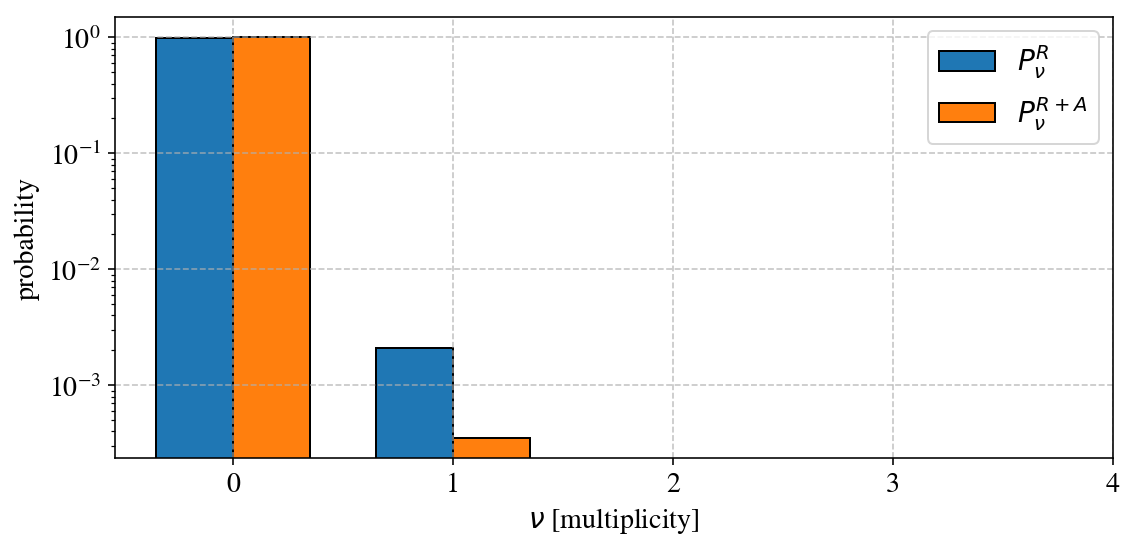

In [15]:
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,4))
# plt.bar(np.array(range(6)),mul_ctr_R[0:6]);
# plt.bar(np.array(range(6)),mul_ctr_RA[0:6]);
nu = np.array(range(4))
rects1 = ax.bar(nu - width/2, mul_ctr_R[0:len(nu)]/np.sum(mul_ctr_R), width, label='$P_{\\nu}^{R}$', edgecolor='k')
rects2 = ax.bar(nu + width/2, mul_ctr_RA[0:len(nu)]/np.sum(mul_ctr_RA), width, label='$P_{\\nu}^{R+A}$', edgecolor='k')

set_axes(ax,'$\\nu$ [multiplicity]','probability',do_add_grid=True,do_add_legend=True,fontsize=14,xticks=(0,1,2,3,4))
ax.set_yscale('log')
plt.tight_layout()

## find singles, triples, doubles

In [16]:
S = len(t)
print S,'singles count, ',float(S)/dT,'per second'

22969 singles count,  2296.9 per second


In [17]:
v = np.array(range(mul_ctr_RA.shape[0]))
Pv = dict()
Pv['R'] = np.array(mul_ctr_R)
Pv['R+A'] = np.array(mul_ctr_RA)

In [18]:
D = (np.sum(v*Pv['R']) - np.sum(v*Pv['R+A']))
print D,'doubles count, ',D/dT,'per second'

40.0 doubles count,  4.0 per second


In [19]:
T = (np.sum(v*(v-1)*Pv['R']/2) - np.sum(v*(v-1)*Pv['R+A']/2) 
     - (np.sum(v*Pv['R+A'])/np.sum(Pv['R+A']))*( np.sum(v*Pv['R']) - np.sum(v*Pv['R+A'])) )
print T,'triples count, ',T/dT,'per second'

-0.013931821150245983 triples count,  -0.0013931821150245983 per second


In [20]:
print 's,d,t: %.1f,%.2f,%.2f Hz'%(float(S)/dT,D/dT,T/dT)

s,d,t: 2296.9,4.00,-0.00 Hz
